In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#import tensorflow as tf
#from tensorflow import keras

#from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
#from keras.layers.core import Activation
#from keras.layers.core import Flatten
#from keras.layers.core import Dropout
#from keras.layers.core import Dense
#from keras.layers import Input
#from keras.optimizers import Adam
#from keras.models import Model

dataset = pd.read_csv('../data/Dataset_refined/complete.csv', sep=',')
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [32]:
right_turns = y[np.where(y > 0.0)]
left_turns = y[np.where(y < 0.0)]
print("Number of right turns: ", right_turns.shape[0])
print("max: ", np.amax(y))
print("mean: ", np.median(y))
print("min: ", np.amin(y))
print("Number of left turns: ", left_turns.shape[0])

Number of right turns:  3846
max:  0.4189
mean:  -0.037106018513441086
min:  -0.4189
Number of left turns:  7051


In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [4]:
#classify data
def classify5classes(data):
    classified_data = []
    limits = []
    parts = 0.4189*2/5
    start = -0.4189
    for i in range(1,5):
        limits.append(start + parts*i)
    
    print(limits)
    for sample in data:
        if sample < limits[0]:
            classified_data.append('Hard_left')
        elif sample >= limits[0] and sample < limits[1] :
            classified_data.append('Slight_left')
        elif sample >= limits[1] and sample < limits[2]:
            classified_data.append('Straight')
        elif sample >= limits[2] and sample < limits[3]:
            classified_data.append('Slight_right')
        elif sample >= limits[3]:
            classified_data.append('Hard_right')
              
    
    return classified_data

In [5]:
#classify data
def classify3classes(data):
    classified_data = []
    limits = []
    parts = 0.4189*2/3
    start = -0.4189
    for i in range(1,3):
        limits.append(start + parts*i)
    
    print(limits)
    for sample in data:
        if sample < limits[0]:
            classified_data.append('left')
        elif sample >= limits[0] and sample < limits[1] :
            classified_data.append('straight')
        elif sample >= limits[1]:
            classified_data.append('right')
              
    
    return classified_data

In [6]:
#classify data
def classify2classes(data):
    classified_data = []
    limits = []
    parts = 0.4189
    start = -0.4189
    for i in range(1,2):
        limits.append(start + parts*i)
    
    print(limits)
    for sample in data:
        if sample < limits[0]:
            classified_data.append('0')
        elif sample >= limits[0]:
            classified_data.append('1')
              
    
    return classified_data

[0.0]
[0.0]


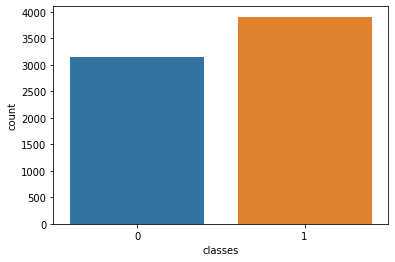

In [7]:
#classify
y_train = classify2classes(y_train)
y_test = classify2classes(y_test)
df = pd.DataFrame(y_train, columns=['classes'])
sns.countplot(x = 'classes',data=df)

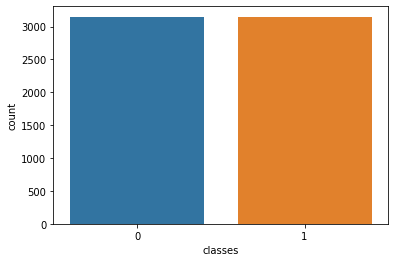

In [8]:
#Undersampling
nm = NearMiss(version=1)
x_train_res, y_train_res = nm.fit_resample(x_train, y_train)
df_res = pd.DataFrame(y_train_res, columns=['classes'])
sns.countplot(x = 'classes',data=df_res)

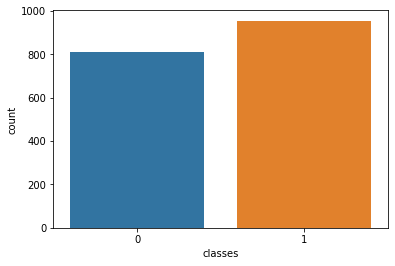

In [9]:
df2 = pd.DataFrame(y_test, columns=['classes'])
sns.countplot(x = 'classes',data=df2)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
#MLP Grid search model
mlp = MLPRegressor(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(80,100,80)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.764 (+/-0.075) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.702 (+/-0.198) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 10, 5), 'learning_rate': 'constant', 'solver': 'adam'}


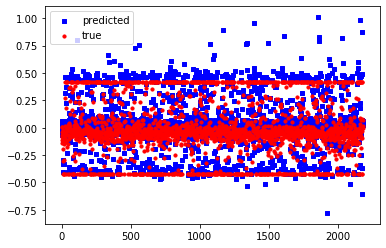

R2:  0.8220449638154935
MSE:  0.01016387315952675


In [35]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = clf.predict(x_test)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(y_pred)), y_pred, s=10, c='b', marker="s", label='predicted')
ax1.scatter(range(len(y_test)),y_test, s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left');
plt.show()

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))

In [36]:
for i in range(10):
    print("pred: ", y_pred[i], ", true: ",y_test[i])

pred:  0.007487478014541998 , true:  -0.06639871746301651
pred:  0.0021346421520805625 , true:  -0.038882441818714135
pred:  0.059140030867858656 , true:  0.003095604712143541
pred:  0.023067802316130454 , true:  0.00302897859364748
pred:  -0.040586812845224224 , true:  -0.13752257823944092
pred:  -0.06711830589436094 , true:  -0.08051855117082596
pred:  -0.0020674077478538277 , true:  -0.11374583840370175
pred:  -0.03615686834091272 , true:  -0.06056630611419678
pred:  -0.11705838754452799 , true:  -0.19837413728237152
pred:  -0.4061769216883706 , true:  -0.4189


In [26]:
#Keras sequential model
inputs = Input(shape=(1081,))

dense1 = Dense(50)(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(70)(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(90)(dense2)
dense3 = Activation("relu")(dense3)

dense4 = Dense(90)(dense3)
dense4 = Activation("relu")(dense4)

dense5 = Dense(90)(dense4)
dense5 = Activation("relu")(dense5)


# softmax classifier
final = Dense(2)(dense5)
final = Activation("softmax")(final)

model = Model(inputs=inputs, outputs=final)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1081)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                54100     
_________________________________________________________________
activation_9 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 54,151
Trainable params: 54,151
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= Adam(), metrics=['accuracy'])

In [28]:
y_train_cat = keras.utils.to_categorical(y_train_res, 2)
y_test_cat = keras.utils.to_categorical(y_test, 2)

x_t, x_v, y_t, y_v = train_test_split(x_train_res, y_train_cat, test_size=0.20, random_state=42)

In [29]:
BATCH_SIZE = 24 
EPOCHS = 50

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 5648 samples, validate on 1413 samples
Epoch 1/50
5648/5648 [==============================] - 1s 170us/step - loss: 0.7848 - mean_squared_error: 0.7848 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 2/50
5648/5648 [==============================] - 1s 113us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 3/50
5648/5648 [==============================] - 1s 99us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 4/50
5648/5648 [==============================] - 1s 91us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 5/50
5648/5648 [==============================] - 1s 95us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 6/50
5648/5648 [==============================] - 1s 89us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 

Epoch 50/50
5648/5648 [==============================] - 0s 82us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506


In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.052272238041931346
Test accuracy: 0.052272237837314606


In [ ]:
#fig, ax = plt.subplots(figsize=(16,10))
y_pred = clf.predict(x_test)
report = classification_report(y_test, y_pred)
plot_confusion_matrix(clf, x_test, y_test,
                        cmap=plt.cm.Blues,
                         normalize='true',
                         xticks_rotation='horizontal')
print(report)